# PPCA in TensorFlow Probability - Part 1: The basis of our model
This is the first part of my PPCA method applied in TensorFlow Probability (TFP) on a small set of generated data. As a start of our PPCA model, we will mostly be re-creating the PPCA of [one of TensorFlow's tutorials of TFP](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_PCA.ipynb). The tutorial has been extended from an $x = Wz$ model to an $x = Wz + \mu$ model. We will start with the code as given in the tutorial.

This folder should also contain a part 2, in which we will analyse some of the errors we stumbled upon in this notebook.

First we import necessary libraries

In [58]:
import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
from mpl_toolkits.mplot3d import Axes3D

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

import os
os.sys.path.append('../Python')
from ppca import PPCA
from rotation_check import rotation_check

We create a function of the original $x = Wz$ model:

In [59]:
Root = tfd.JointDistributionCoroutine.Root
def probabilistic_pca_basis(data_dim, latent_dim, num_datapoints):
    sigma = yield Root(tfd.Independent(
        tfd.Uniform(low=0, high=5, name='sigma')))
    w = yield Root(tfd.Independent(
        tfd.Uniform(low=-10.0*tf.ones([data_dim, latent_dim]),
                 high=10.0*tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
    x = yield tfd.Independent(tfd.Normal(
      loc=tf.matmul(w, z),
      scale=sigma,
      name="x"), reinterpreted_batch_ndims=2)

In [60]:
num_datapoints = 10000
data_dim = 3
latent_dim = 2

concrete_ppca_model_basis = functools.partial(probabilistic_pca_basis,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints)

model_basis = tfd.JointDistributionCoroutine(concrete_ppca_model_basis)


And we generate some data:

Principal axes:
sigma:  1.470694
W:
 [[0.9183903 8.196262 ]
 [3.027584  8.609667 ]
 [7.776703  5.99004  ]]
z:
 [[ 0.13657902 -0.48769036  0.36456937 ... -0.4529295   1.3431886
   1.1937388 ]
 [ 1.4640507   0.85882604  0.6819721  ... -0.22454739 -0.27939177
  -0.38050663]]


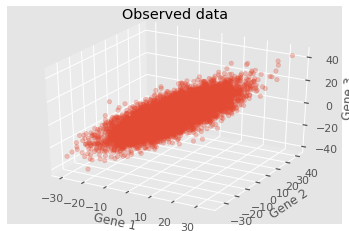

In [61]:
actual_sigma, actual_w, actual_z, x_train = model_basis.sample()

print("Principal axes:")
print('sigma: ', actual_sigma.numpy())
print('W:\n',actual_w.numpy())
print('z:\n',actual_z.numpy())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[0,:],x_train[1,:],x_train[2,:], alpha=0.3)
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()


The error is mimized numerically:

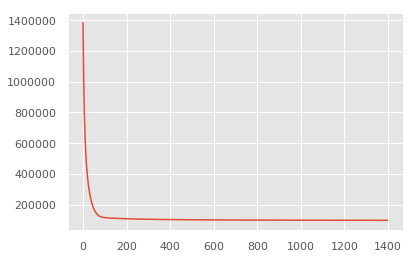

In [62]:
sigma = tf.Variable(1.0, dtype=tf.float32)
w = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)

target_log_prob_fn = lambda sigma, w, z: model_basis.log_prob((sigma, w, z, x_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(sigma, w, z),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=1500)
plt.plot(losses)
plt.show()

And we end up with a model that predicts the $x$ values acurately, based on our guesses of $z$ and $W$.

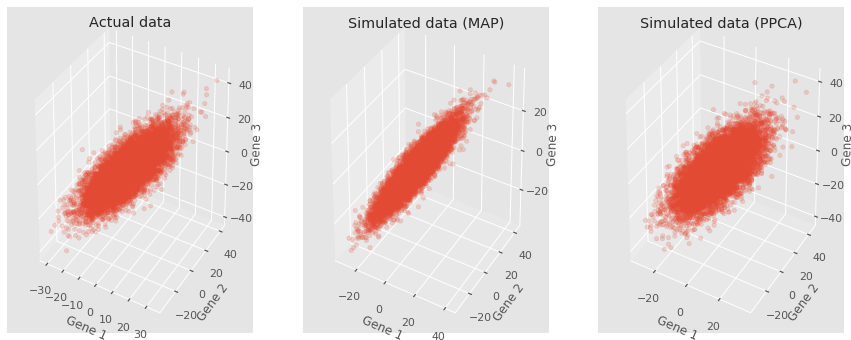

Mean actual data:  [0.08943858 0.11605427 0.08201571] , std.dev:  [8.423552 9.271999 9.889939]
Mean PPCA data:  [0.10262821 0.10374385 0.12461174] , std.dev:  [ 8.906862  9.904465 10.302612]
Mean TFP data:  [0.08019143 0.09404496 0.08172762] , std.dev:  [8.410332 9.65028  9.490662]


In [74]:
_, _, _, x_generated = model_basis.sample(value=(sigma, w, z, None))

# Bishops PPCA
ppca = PPCA()
ppca.fit(x_train.numpy().T, mu = np.zeros(data_dim)[np.newaxis].T)
mu_ppca, sigma_ppca, w_ppca = ppca.parameters()
z_ppca = np.linalg.lstsq(w_ppca,x_train)[0]
x_ppca = tfd.Normal(loc=tf.matmul(tf.Variable(w_ppca,dtype=tf.float32),tf.Variable(z_ppca,dtype=tf.float32)),scale=sigma,name="x_ppca").sample()

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter(x_train[0,:],x_train[1,:],x_train[2,:], alpha=0.2)
ax.set_title('Actual data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter(x_generated[0,:],x_generated[1,:],x_generated[2,:], alpha=0.2)
ax.set_title('Simulated data (MAP)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter(x_ppca[0,:],x_ppca[1,:],x_ppca[2,:], alpha=0.2)
ax.set_title('Simulated data (PPCA)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

print('Mean actual data: ', np.mean(x_train, axis=1), ', std.dev: ', np.std(x_train, axis=1))
print('Mean PPCA data: ', np.mean(x_ppca, axis=1), ', std.dev: ', np.std(x_ppca, axis=1))
print('Mean TFP data: ', np.mean(x_generated, axis=1), ', std.dev: ', np.std(x_generated, axis=1))

Let's compare our findings with the real values and the values as found by the original PPCA.

In [64]:
z = np.linalg.lstsq(w.numpy(),x_train)[0]
print("MAP-estimated axes:")
print('real variance: ', actual_sigma.numpy()**2)
print('PPCA variance: ', sigma_ppca)
print('simulated variance: ', sigma.numpy()**2)
print()
print('real z:\n', actual_z.numpy())
print('PPCA z:\n', z_ppca)
print('simulated z:\n', z)
print()
print('real W:\n', actual_w.numpy())
print('PPCA W:\n', w_ppca)
print('simulated W:\n', w.numpy())
print()

MAP-estimated axes:
real variance:  2.1629406824619224
PPCA variance:  2.1896516162024615
simulated variance:  10.460424399668739

real z:
 [[ 0.13657902 -0.48769036  0.36456937 ... -0.4529295   1.3431886
   1.1937388 ]
 [ 1.4640507   0.85882604  0.6819721  ... -0.22454739 -0.27939177
  -0.38050663]]
PPCA z:
 [[-1.2278138  -0.63674533 -0.97181404 ...  0.48926261 -0.52421176
  -0.19678234]
 [-0.03578529 -0.40636861 -0.34116414 ... -0.21360314  0.93397057
   1.28507225]]
simulated z:
 [[ 0.5372661   0.27683815  0.42403635 ... -0.21299668  0.2316721
   0.08993948]
 [ 0.5372661   0.27683815  0.42403635 ... -0.21299668  0.2316721
   0.08993948]]

real W:
 [[0.9183903 8.196262 ]
 [3.027584  8.609667 ]
 [7.776703  5.99004  ]]
PPCA W:
 [[-7.71602443 -3.14587831]
 [-9.33484418 -1.1287362 ]
 [-8.6002073   4.04760597]]
simulated W:
 [[ 8.842154   8.842154 ]
 [10.330956  10.330956 ]
 [10.1661415 10.1661415]]



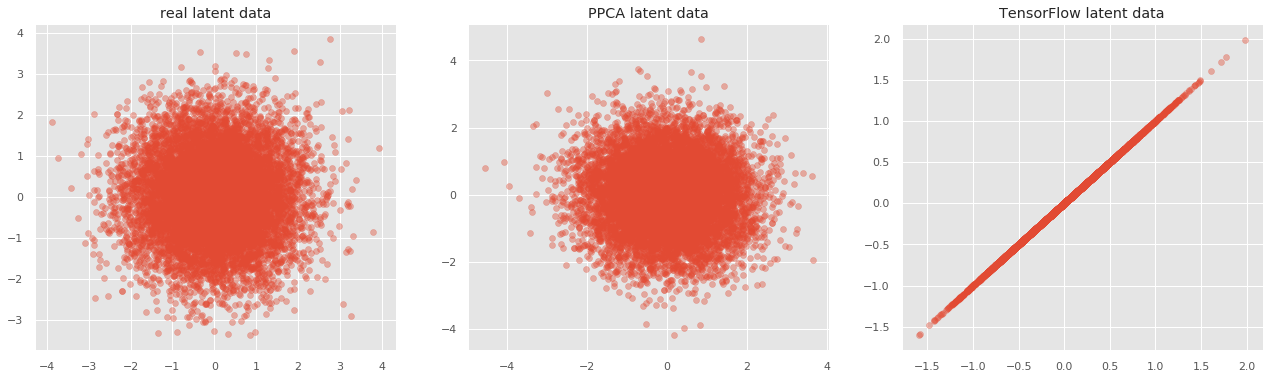

Mean actual latent data:  [0.00251122 0.01107448] , std.dev:  [0.99609685 1.0059552 ]
Mean PPCA latent data:  [-0.01123464 -0.00291759] , std.dev:  [1.00453455 1.03904276]
Mean TFP latent data:  [0.00489755 0.00489755] , std.dev:  [0.43958202 0.43958202]


In [73]:
fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(1,3,1)
ax.scatter(actual_z[0,:], actual_z[1,:], alpha=0.4)
ax.set_title('real latent data')
ax = fig.add_subplot(1,3,2)
ax.scatter(z_ppca[0,:], z_ppca[1,:], alpha=0.4)
ax.set_title('PPCA latent data')
ax = fig.add_subplot(1,3,3)
ax.scatter(z[0,:], z[1,:], alpha=0.4)
ax.set_title('TensorFlow latent data')
plt.show()

print('Mean actual latent data: ', np.mean(actual_z, axis=1), ', std.dev: ', np.std(actual_z, axis=1))
print('Mean PPCA latent data: ', np.mean(z_ppca, axis=1), ', std.dev: ', np.std(z_ppca, axis=1))
print('Mean TFP latent data: ', np.mean(z, axis=1), ', std.dev: ', np.std(z, axis=1))

In [76]:
np.corrcoef(z[0,:], z[1,:])

array([[1., 1.],
       [1., 1.]])

In [66]:
print('Original W and Simulated W:')
rotation_check(actual_w.numpy(),w.numpy(), verbose=True)
rotation_check(actual_w.numpy(),w.numpy(), method='angles', verbose=True)
print()
print('Original W and PPCA W:')
rotation_check(actual_w.numpy(),w_ppca, verbose=True)
rotation_check(actual_w.numpy(),w_ppca, method='angles', verbose=True)
print()
print('PPCA W and simulated W:')
rotation_check(w_ppca,w.numpy(), verbose=True)
rotation_check(w_ppca,w.numpy(), method='angles', verbose=True)

Original W and Simulated W:
These might not be rotations. det(R)= 0.0 R.T*R=
 [[1.3098238 1.3098238]
 [1.3098238 1.3098238]]
These matrices differ in magnitude on row 2 as they are of length 68.022 and 156.367 (0.435x).
These matrices differ in magnitude on row 2 as they are of length 83.293 and 206.701 (0.403x).
These matrices differ in magnitude on row 2 as they are of length 96.358 and 213.457 (0.451x).
These matrices differ at least on the angle between axis 0 and 1 as they are 0.227 and 0.000.
These matrices differ at least on the angle between axis 0 and 2 as they are 0.576 and 0.000.
These matrices differ at least on the angle between axis 1 and 2 as they are 0.803 and nan.

Original W and PPCA W:
These might not be rotations. det(R)= 1.000219717948644 R.T*R=
 [[1.00670767 0.06495227]
 [0.06495227 0.99796426]]
These matrices are approximately equal in magnitude on row 2 as they are of length 68.022 and 69.434 (0.980x).
These matrices are approximately equal in magnitude on row 2

False

In [67]:
print('Actual WW^T:\n',np.matmul(actual_w.numpy(),actual_w.numpy().T))
print('PPCA WW^T:\n',np.matmul(w_ppca,w_ppca.T))
print('TFP WW^T:\n',np.matmul(w.numpy(),w.numpy().T))

Actual WW^T:
 [[68.022156 73.347595 56.237988]
 [73.347595 83.292625 75.11687 ]
 [56.237988 75.11687  96.35769 ]]
PPCA WW^T:
 [[69.43358334 75.5787525  53.62613379]
 [75.5787525  88.41336135 75.7129157 ]
 [53.62613379 75.7129157  90.34667962]]
TFP WW^T:
 [[156.36736 182.6958  179.78117]
 [182.6958  213.45732 210.05193]
 [179.78117 210.05193 206.70087]]


## Addition of $\mu$ variable to the model:
Because we want to model the relation between our latent and observed data fundamentally different, we have to create a new model. Also, we wish to compare both models, with the same sets of data. For this reason, we create one function that outputs $x$ variables as generated by the original $x=Wz$-model and the $x=Wz+\mu$-model. We create the model and generate random data similarly as done before:

In [78]:
Root = tfd.JointDistributionCoroutine.Root
def probabilistic_pca_multi(data_dim, latent_dim, num_datapoints):
    sigma = yield Root(tfd.Independent(
        tfd.Uniform(low=0, high=5, name='sigma')))
    w = yield Root(tfd.Independent(
        tfd.Uniform(low=-10.0*tf.ones([data_dim, latent_dim]),
                 high=10.0*tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
    mu = yield Root(tfd.Independent(
        tfd.Uniform(low=tf.zeros([data_dim,1]), high=15*tf.ones([data_dim,1]), name='sigma')))
    x_original = yield tfd.Independent(tfd.Normal(
        loc=tf.matmul(w, z),
        scale=sigma,
        name="x_original"), reinterpreted_batch_ndims=2)
    x_mu = yield tfd.Independent(tfd.Normal(
        loc=tf.matmul(w, z)+mu,
        scale=sigma,
        name="x_mu"), reinterpreted_batch_ndims=2)

concrete_ppca_model_multi = functools.partial(probabilistic_pca_multi,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints)

model_multi = tfd.JointDistributionCoroutine(concrete_ppca_model_multi)

In [79]:
actual_sigma, actual_w, actual_z, actual_mu, x_orig_train, x_mu_train = model_multi.sample()

print("Principal axes:")
print('sigma: ', actual_sigma.numpy())
print('mu:\n', actual_mu.numpy())
print('W:\n',actual_w.numpy())
print('z:\n',actual_z.numpy())

Principal axes:
sigma:  1.470694
mu:
 [[12.621599 ]
 [ 1.7367357]
 [ 0.7182938]]
W:
 [[0.9183903 8.196262 ]
 [3.027584  8.609667 ]
 [7.776703  5.99004  ]]
z:
 [[ 0.13657902 -0.48769036  0.36456937 ... -0.4529295   1.3431886
   1.1937388 ]
 [ 1.4640507   0.85882604  0.6819721  ... -0.22454739 -0.27939177
  -0.38050663]]


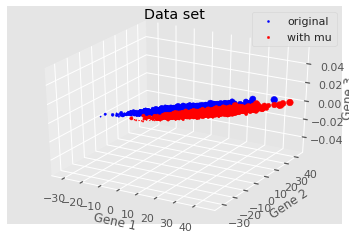

In [80]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.scatter(x_orig_train[0, :], x_orig_train[1, :], x_orig_train[2, :], color='blue', alpha=1, label='original')
plt.scatter(x_mu_train[0, :], x_mu_train[1, :], x_mu_train[2, :], color='red', alpha=1,label='with mu')
title = ax.set_title("Data set")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

The scatter plot shows how the data is very much alike, except for the relocation of the mean of $x$ in both dimensions (which is the addition of a non-zero $\mu$). Shortly after generating this data, it became apparaent that to mimize the error according to both models (the original- and the $\mu$-model), we need separate functions for both. The original function was created already in the example above, so we create another additional function for our $\mu$ model.

In [81]:
def probabilistic_pca_mu(data_dim, latent_dim, num_datapoints):
    sigma = yield Root(tfd.Independent(
        tfd.Uniform(low=0, high=5, name='sigma')))
    w = yield Root(tfd.Independent(
        tfd.Uniform(low=-10.0*tf.ones([data_dim, latent_dim]),
                 high=10.0*tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
    mu = yield Root(tfd.Independent(
        tfd.Uniform(low=tf.zeros([data_dim,1]), high=15*tf.ones([data_dim,1]), name='sigma')))
    x_mu = yield tfd.Independent(tfd.Normal(
        loc=tf.matmul(w, z)+mu,
        scale=sigma,
        name="x_mu"), reinterpreted_batch_ndims=2)
    

concrete_ppca_model_mu = functools.partial(probabilistic_pca_mu,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints)

model_mu = tfd.JointDistributionCoroutine(concrete_ppca_model_mu)

Now we optimize the values of $z$ and $W$ for both models, and $\mu$ for the later model. The results are plotted below.

In [82]:
sigma_orig = tf.Variable(1.0, dtype=tf.float32)
w_orig = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z_orig = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)

target_log_prob_fn_basis = lambda sigma_orig, w_orig, z_orig: model_basis.log_prob((sigma_orig, w_orig, z_orig, x_orig_train))
losses_basis = tfp.math.minimize(lambda: -target_log_prob_fn_basis(sigma_orig, w_orig, z_orig),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=300)

sigma_mu = tf.Variable(1.0, dtype=tf.float32)
w_mu = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z_mu = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
mu_mu = tf.Variable(np.ones([data_dim,1]), dtype=tf.float32)

target_log_prob_fn_mu = lambda sigma_mu, w_mu, z_mu, mu_mu: model_mu.log_prob((sigma_mu, w_mu, z_mu, mu_mu, x_mu_train))
losses_mu = tfp.math.minimize(lambda: -target_log_prob_fn_mu(sigma_mu, w_mu, z_mu, mu_mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=300)

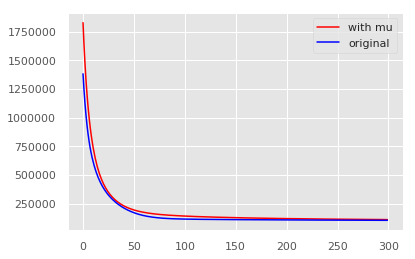

In [83]:
plt.plot(losses_mu[:,0], label='with mu', color='red')
plt.plot(losses_basis, label='original', color='blue')
plt.legend()
plt.show()

Original model:
MAP-estimated axes:
real variance:  2.1629406824619224
PPCA variance:  2.1747969246067913
simulated variance:  7.206703987160893

actual W:
 [[0.9183903 8.196262 ]
 [3.027584  8.609667 ]
 [7.776703  5.99004  ]]
PPCA W:
 [[-7.68638376 -3.15511084]
 [-9.29281165 -1.15887905]
 [-8.63975014  4.05343174]]
Estimated W:
 [[4.3609867 4.3609867]
 [5.093167  5.093167 ]
 [5.002608  5.002608 ]]

actual Z:
 [[ 0.13657902 -0.48769036  0.36456937 ... -0.4529295   1.3431886
   1.1937388 ]
 [ 1.4640507   0.85882604  0.6819721  ... -0.22454739 -0.27939177
  -0.38050663]]
PPCA Z:
 [[-0.92755743 -0.12904263 -0.01426517 ...  0.88724139  0.43618206
   0.38034428]
 [ 2.79851303  1.00038538 -0.95336257 ... -0.32829982  0.50461759
  -1.01690303]]
Estimated Z:
 [[ 0.8579301   0.11567682  0.00490276 ... -0.7952904  -0.3842205
  -0.3472621 ]
 [ 0.8579301   0.11567682  0.00490276 ... -0.7952904  -0.3842205
  -0.3472621 ]]



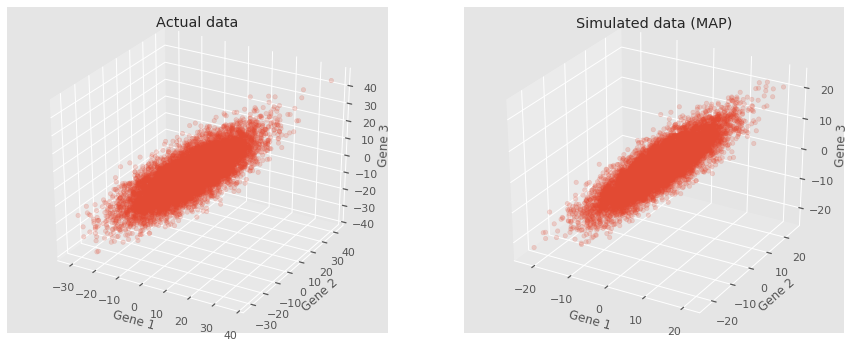

In [84]:
ppca = PPCA()
ppca.fit(x_orig_train.numpy().T, mu = np.zeros(data_dim)[np.newaxis].T)
mu_ppca, sigma_ppca, w_ppca = ppca.parameters()
z_ppca = np.linalg.lstsq(w_ppca,x_train)[0]
z_orig = np.linalg.lstsq(w_orig.numpy(),x_train)[0]


print('Original model:')
print("MAP-estimated axes:")
print('real variance: ', actual_sigma.numpy()**2)
print('PPCA variance: ', sigma_ppca)
print('simulated variance: ', sigma_orig.numpy()**2)
print()
print('actual W:\n',actual_w.numpy())
print('PPCA W:\n',w_ppca)
print('Estimated W:\n',w_orig.numpy())
print()
print('actual Z:\n',actual_z.numpy())
print('PPCA Z:\n',z_ppca)
print('Estimated Z:\n',z_orig)
print()

_, _, _, x_generated_orig = model_basis.sample(value=(sigma_orig, w_orig, z_orig, None))


fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(x_orig_train[0,:],x_orig_train[1,:],x_orig_train[2,:], alpha=0.2)
ax.set_title('Actual data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(x_generated_orig[0,:],x_generated_orig[1,:],x_generated_orig[2,:], alpha=0.2)
ax.set_title('Simulated data (MAP)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

Model with mu:
MAP-estimated axes:
real variance:  2.1629406824619224
PPCA variance:  2.1799240695329503
PyStan variance:  7.203214900876048

actual W:
 [[0.9183903 8.196262 ]
 [3.027584  8.609667 ]
 [7.776703  5.99004  ]]
PPCA W:
 [[-7.69021048 -3.13402155]
 [-9.34763069 -1.12960269]
 [-8.61339     4.02401308]]
PyStan W:
 [[4.3746915 4.3746915]
 [4.9593253 4.9593253]
 [4.7136636 4.7136636]]

actual Z:
 [[ 0.13657902 -0.48769036  0.36456937 ... -0.4529295   1.3431886
   1.1937388 ]
 [ 1.4640507   0.85882604  0.6819721  ... -0.22454739 -0.27939177
  -0.38050663]]
PPCA Z:
 [[-0.91970422 -0.12859201 -0.01567176 ...  0.88437543  0.43601283
   0.37794475]
 [ 2.81442884  1.01087354 -0.95897293 ... -0.33282559  0.50565724
  -1.02450233]]
PyStan Z:
 [[ 0.8674639   0.11048213  0.01169292 ... -0.818448   -0.39970666
  -0.35108072]
 [ 0.8674639   0.11048213  0.01169292 ... -0.818448   -0.39970666
  -0.35108072]]

actual mu:
 [[12.621599 ]
 [ 1.7367357]
 [ 0.7182938]]
PPCA mu:
 [[12.68384  ]
 [ 1.

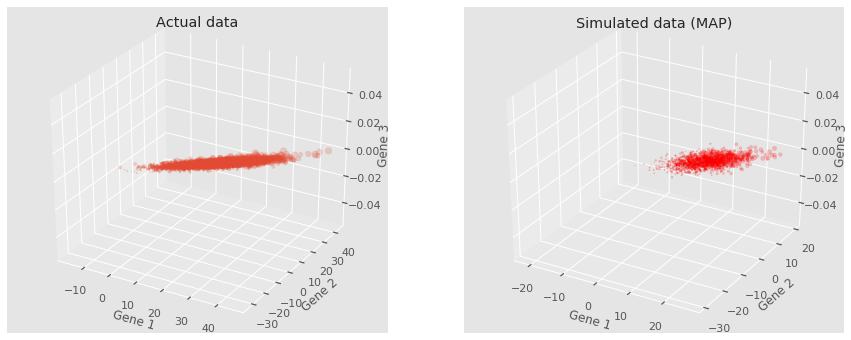

In [85]:
ppca = PPCA()
ppca.fit(x_mu_train.numpy().T)
mu_ppca, sigma_ppca, w_ppca = ppca.parameters()
z_ppca = np.linalg.lstsq(w_ppca,x_train)[0]
z_mu = np.linalg.lstsq(w_mu.numpy(),x_train)[0]

print('Model with mu:')
print("MAP-estimated axes:")
print('real variance: ', actual_sigma.numpy()**2)
print('PPCA variance: ', sigma_ppca)
print('PyStan variance: ', sigma_mu.numpy()**2)
print()
print('actual W:\n',actual_w.numpy())
print('PPCA W:\n',w_ppca)
print('PyStan W:\n',w_mu.numpy())
print()
print('actual Z:\n',actual_z.numpy())
print('PPCA Z:\n',z_ppca)
print('PyStan Z:\n',z_mu)
print()
print('actual mu:\n',actual_mu.numpy())
print('PPCA mu:\n',mu_ppca)
print('PyStan mu:\n',mu_mu.numpy())

_, _, _, _, x_generated_mu = model_mu.sample(value=(sigma_mu, w_mu, z_mu, mu_mu, None))

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,2,1, projection='3d')
plt.scatter(x_mu_train[0, :], x_mu_train[1, :], x_mu_train[2, :], alpha=0.2, label='original')
ax.set_title('Actual data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,2,2, projection='3d')
plt.scatter(x_generated_mu[0, :], x_generated_mu[1, :], x_generated_mu[2, :], color='red', alpha=0.2,label='with mu')
ax.set_title('Simulated data (MAP)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()







The original model (which has data centered around zero) works as before. Clearly noticable is that the new $\mu$-model predicts the data 'somewhat' accurately, but the covariance between dimensions looks unmatching with the original data. On first sight, one might conclude that $\mu$ was predicted correctly but $W$ or $z$ was not. Upon further inspection however, we see that $\mu$ is not predicted correctly at all! The mean position of our data is recreated by adjusting the $W$ matrix, which results in our data taking an elliptical form that 'points in the wrong direction'. For this reason, it might be better to predict $\mu$ first, before trying to guess $W$ or $z$. This was done by optimizing another model which <i>only</i> contained $\mu$ (i.e. $x = \mu$).

Edit: The error described above is not always apparent, but it definitely arises sometimes!

In [86]:
def probabilistic_pca_onlymu(data_dim, latent_dim, num_datapoints):
    mu = yield Root(tfd.Independent(
        tfd.Uniform(low=tf.zeros([data_dim,1]), high=15*tf.ones([data_dim,1]), name='sigma')))
    x_mu = yield tfd.Independent(tfd.Normal(
        loc=mu,
        scale=1,
        name="x_mu"), reinterpreted_batch_ndims=2)
concrete_ppca_model_onlymu = functools.partial(probabilistic_pca_onlymu,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints)

model_onlymu = tfd.JointDistributionCoroutine(concrete_ppca_model_onlymu)

This time we optimize $\mu$ first, and then the complete $\mu$-model:

In [87]:
sigma_mu = tf.Variable(1.0, dtype=tf.float32)
w_mu = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z_mu = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
mu_mu = tf.Variable(np.ones([data_dim,1]), dtype=tf.float32)

target_log_prob_fn_onlymu = lambda mu_mu: model_onlymu.log_prob((mu_mu, x_mu_train))
losses_onlymu = tfp.math.minimize(lambda: -target_log_prob_fn_onlymu(mu_mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=300)

target_log_prob_fn_mu = lambda sigma_mu, w_mu, z_mu, mu_mu: model_mu.log_prob((sigma_mu, w_mu, z_mu, mu_mu, x_mu_train))
losses_mu = tfp.math.minimize(lambda: -target_log_prob_fn_mu(sigma_mu, w_mu, z_mu, mu_mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=300)

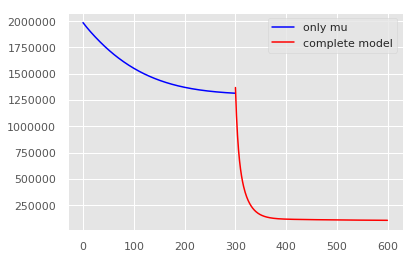

In [88]:
plt.plot(losses_onlymu[:,0], label='only mu', color='blue')
plt.plot(range(300,600), losses_mu[:,0], label='complete model', color='red')
plt.legend()
plt.show()

As we can see, most of the error is reduced by optimizing $\mu$, while the complete model only resolves the last bits of error. The final results of our model are plotted below. This time, our predicted data fits the original data.

Model with mu:
MAP-estimated axes:
real variance:  2.1629406824619224
PPCA variance:  2.1799240695329503
PyStan variance:  6.986460447086756

actual W:
 [[0.9183903 8.196262 ]
 [3.027584  8.609667 ]
 [7.776703  5.99004  ]]
PPCA W:
 [[-7.69021048 -3.13402155]
 [-9.34763069 -1.12960269]
 [-8.61339     4.02401308]]
PyStan W:
 [[4.4022717 4.4022717]
 [5.1022882 5.1022882]
 [5.0340147 5.0340147]]

actual Z:
 [[ 0.13657902 -0.48769036  0.36456937 ... -0.4529295   1.3431886
   1.1937388 ]
 [ 1.4640507   0.85882604  0.6819721  ... -0.22454739 -0.27939177
  -0.38050663]]
PPCA Z:
 [[-0.91970422 -0.12859201 -0.01567176 ...  0.88437543  0.43601283
   0.37794475]
 [ 2.81442884  1.01087354 -0.95897293 ... -0.33282559  0.50565724
  -1.02450233]]
PyStan Z:
 <tf.Variable 'Variable:0' shape=(2, 10000) dtype=float32, numpy=
array([[ 1.3117015 ,  0.5630544 ,  0.82014865, ..., -0.04374246,
         0.5187635 ,  0.26598933],
       [ 1.3117015 ,  0.5630544 ,  0.82014865, ..., -0.04374246,
         0.5187635

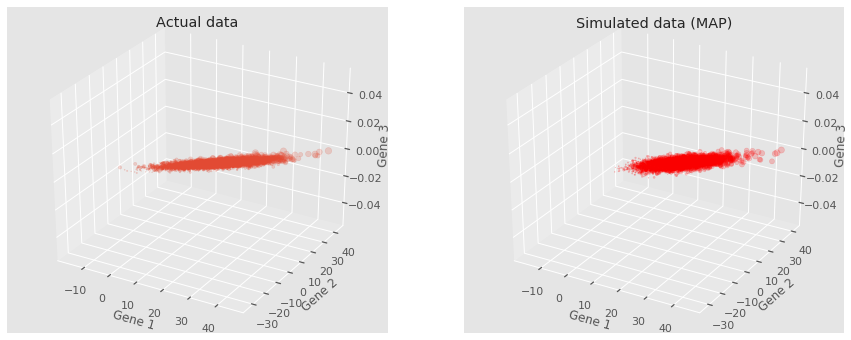

In [89]:
print('Model with mu:')
print("MAP-estimated axes:")
print('real variance: ', actual_sigma.numpy()**2)
print('PPCA variance: ', sigma_ppca)
print('PyStan variance: ', sigma_mu.numpy()**2)
print()
print('actual W:\n',actual_w.numpy())
print('PPCA W:\n',w_ppca)
print('PyStan W:\n',w_mu.numpy())
print()
print('actual Z:\n',actual_z.numpy())
print('PPCA Z:\n',z_ppca)
print('PyStan Z:\n',z_mu)
print()
print('actual mu:\n',actual_mu.numpy())
print('PPCA mu:\n',mu_ppca)
print('PyStan mu:\n',mu_mu.numpy())

_, _, _, _, x_generated_mu = model_mu.sample(value=(sigma_mu, w_mu, z_mu, mu_mu, None))

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,2,1, projection='3d')
plt.scatter(x_mu_train[0, :], x_mu_train[1, :], x_mu_train[2, :], alpha=0.2, label='original')
ax.set_title('Actual data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,2,2, projection='3d')
plt.scatter(x_generated_mu[0, :], x_generated_mu[1, :], x_generated_mu[2, :], color='red', alpha=0.2,label='with mu')
ax.set_title('Simulated data (MAP)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

Instead of building a model to optimize $\mu$, we could of course also just use the analytical solution ($\mu = \frac{1}{N} \sum^N_{n=1}x_n$), which is quicker and more accurate:

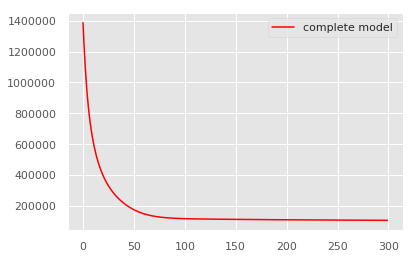

In [90]:
sigma_mu = tf.Variable(1.0, dtype=tf.float32)
w_mu = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z_mu = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
mu_mu = tf.expand_dims(tf.reduce_mean(x_mu_train, 1),1)

target_log_prob_fn_mu = lambda sigma_mu, w_mu, z_mu, mu_mu: model_mu.log_prob((sigma_mu, w_mu, z_mu, mu_mu, x_mu_train))
losses_mu = tfp.math.minimize(lambda: -target_log_prob_fn_mu(sigma_mu, w_mu, z_mu, mu_mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=300)

plt.plot(losses_mu[:,0], label='complete model', color='red')
plt.legend()
plt.show()

Model with mu:
MAP-estimated axes:
real variance:  2.1629406824619224
PPCA variance:  2.1799240695329503
PyStan variance:  7.194804123342294

actual W:
 [[0.9183903 8.196262 ]
 [3.027584  8.609667 ]
 [7.776703  5.99004  ]]
PPCA W:
 [[-7.69021048 -3.13402155]
 [-9.34763069 -1.12960269]
 [-8.61339     4.02401308]]
PyStan W:
 [[4.3403425 4.3403425]
 [5.0712256 5.0712256]
 [4.9902744 4.9902744]]

actual Z:
 [[ 0.13657902 -0.48769036  0.36456937 ... -0.4529295   1.3431886
   1.1937388 ]
 [ 1.4640507   0.85882604  0.6819721  ... -0.22454739 -0.27939177
  -0.38050663]]
PPCA Z:
 [[-0.91970422 -0.12859201 -0.01567176 ...  0.88437543  0.43601283
   0.37794475]
 [ 2.81442884  1.01087354 -0.95897293 ... -0.33282559  0.50565724
  -1.02450233]]
PyStan Z:
 [[ 1.1678247   0.41498816  0.6745041  ... -0.1951142   0.37201247
   0.1172002 ]
 [ 1.1678247   0.41498816  0.6745041  ... -0.1951142   0.37201247
   0.1172002 ]]

actual mu:
 [[12.621599 ]
 [ 1.7367357]
 [ 0.7182938]]
PPCA mu:
 [[12.68384  ]
 [ 1.

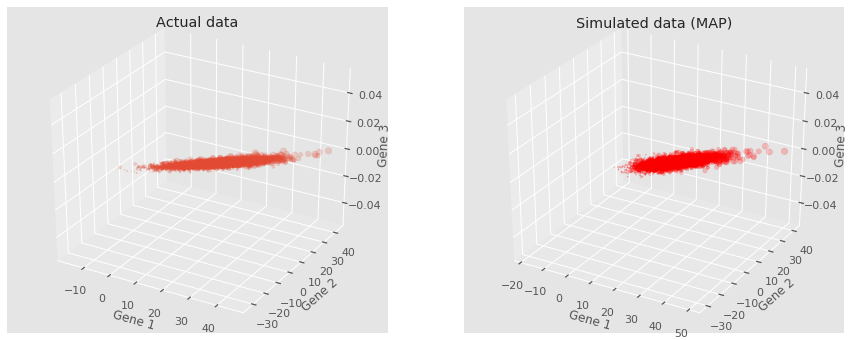

In [92]:
print('Model with mu:')
print("MAP-estimated axes:")
print('real variance: ', actual_sigma.numpy()**2)
print('PPCA variance: ', sigma_ppca)
print('PyStan variance: ', sigma_mu.numpy()**2)
print()
print('actual W:\n',actual_w.numpy())
print('PPCA W:\n',w_ppca)
print('PyStan W:\n',w_mu.numpy())
print()
print('actual Z:\n',actual_z.numpy())
print('PPCA Z:\n',z_ppca)
print('PyStan Z:\n',z_mu.numpy())
print()
print('actual mu:\n',actual_mu.numpy())
print('PPCA mu:\n',mu_ppca)
print('PyStan mu:\n',mu_mu.numpy())

_, _, _, _, x_generated_mu = model_mu.sample(value=(sigma_mu, w_mu, z_mu, mu_mu, None))

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,2,1, projection='3d')
plt.scatter(x_mu_train[0, :], x_mu_train[1, :], x_mu_train[2, :], alpha=0.2, label='original')
ax.set_title('Actual data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,2,2, projection='3d')
plt.scatter(x_generated_mu[0, :], x_generated_mu[1, :], x_generated_mu[2, :], color='red', alpha=0.2,label='with mu')
ax.set_title('Simulated data (MAP)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

In [93]:
print('Original W and Simulated W:')
rotation_check(actual_w.numpy(),w_mu.numpy(), verbose=True)
rotation_check(actual_w.numpy(),w_mu.numpy(), method='angles', verbose=True)
print()
print('Original W and PPCA W:')
rotation_check(actual_w.numpy(),w_ppca, verbose=True)
rotation_check(actual_w.numpy(),w_ppca, method='angles', verbose=True)
print()
print('PPCA W and simulated W:')
rotation_check(w_ppca,w_mu.numpy(), verbose=True)
rotation_check(w_ppca,w_mu.numpy(), method='angles', verbose=True)

Original W and Simulated W:
These might not be rotations. det(R)= 0.0 R.T*R=
 [[0.31561035 0.31561035]
 [0.31561035 0.31561035]]
These matrices differ in magnitude on row 2 as they are of length 68.022 and 37.677 (1.805x).
These matrices differ in magnitude on row 2 as they are of length 83.293 and 49.806 (1.672x).
These matrices differ in magnitude on row 2 as they are of length 96.358 and 51.435 (1.873x).
These matrices differ at least on the angle between axis 0 and 1 as they are 0.227 and 0.000.
These matrices differ at least on the angle between axis 0 and 2 as they are 0.576 and nan.
These matrices differ at least on the angle between axis 1 and 2 as they are 0.803 and nan.

Original W and PPCA W:
These might not be rotations. det(R)= 0.9955757347175296 R.T*R=
 [[1.00643526 0.0610594 ]
 [0.0610594  0.9885378 ]]
These matrices are approximately equal in magnitude on row 2 as they are of length 68.022 and 68.961 (0.986x).
These matrices are approximately equal in magnitude on row 2

False

And we end up with the same result!
However, even though we manage to reproduce $x$ visually, $W$, $\sigma$ and $z$ are not estimated accurately. In part 2 of these PPCA in TFP series, we will try to make sure that we are not only able to recreate $x$, but that we are also able to generate accurate estimates for all parameters.